In [ ]:
# (i) Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
# (ii) Import dataset
df = pd.read_csv('breast_cancer_wisconsin_diagnostic.csv')
target = 'Diagnosis'

In [ ]:
# (iii) EDA and Preprocessing

def is_normal(series):
    skew = series.skew()
    return -0.5 <= skew <= 0.5

def has_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()
    return outliers > 0

In [ ]:
# Separate types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if target in categorical_cols:
    categorical_cols.remove(target)
numerical_cols = [col for col in numerical_cols if col != target]

# --- Missing Values Handling ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in numerical_cols:
            if is_normal(df[col]):
                if has_outliers(df[col]):
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)  # categorical

# --- Outlier Replacing (for numerical columns only) ---
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    if is_normal(df[col]):
        replacement_value = df[col].mean()
    else:
        replacement_value = df[col].median()

    # Replace outliers
    df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), replacement_value, df[col])

In [ ]:
# --- Drop rows where target is missing ---
df.dropna(subset=[target], inplace=True)

# --- Feature Engineering (if needed) ---
df["circularity1"] = 4 * np.pi * df["area1"] / (df["perimeter1"] ** 2 + 1e-6)
df["area_per_radius1"] = df["area1"] / (df["radius1"] + 1e-6)

In [ ]:
# --- Encoding categorical features ---
is_classification = True

if is_classification:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])  # encode target
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])  # label encoding for classification
else:
    # Regression: target guided ordinal encoding
    for col in categorical_cols:
        ordered_labels = df.groupby(col)[target].mean().sort_values().index
        mapping = {k: i for i, k in enumerate(ordered_labels)}
        df[col] = df[col].map(mapping)

In [ ]:
# --- Scaling ---
for col in numerical_cols:
    if is_normal(df[col]):
        scaler = StandardScaler()
    elif has_outliers(df[col]):
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    df[[col]] = scaler.fit_transform(df[[col]])

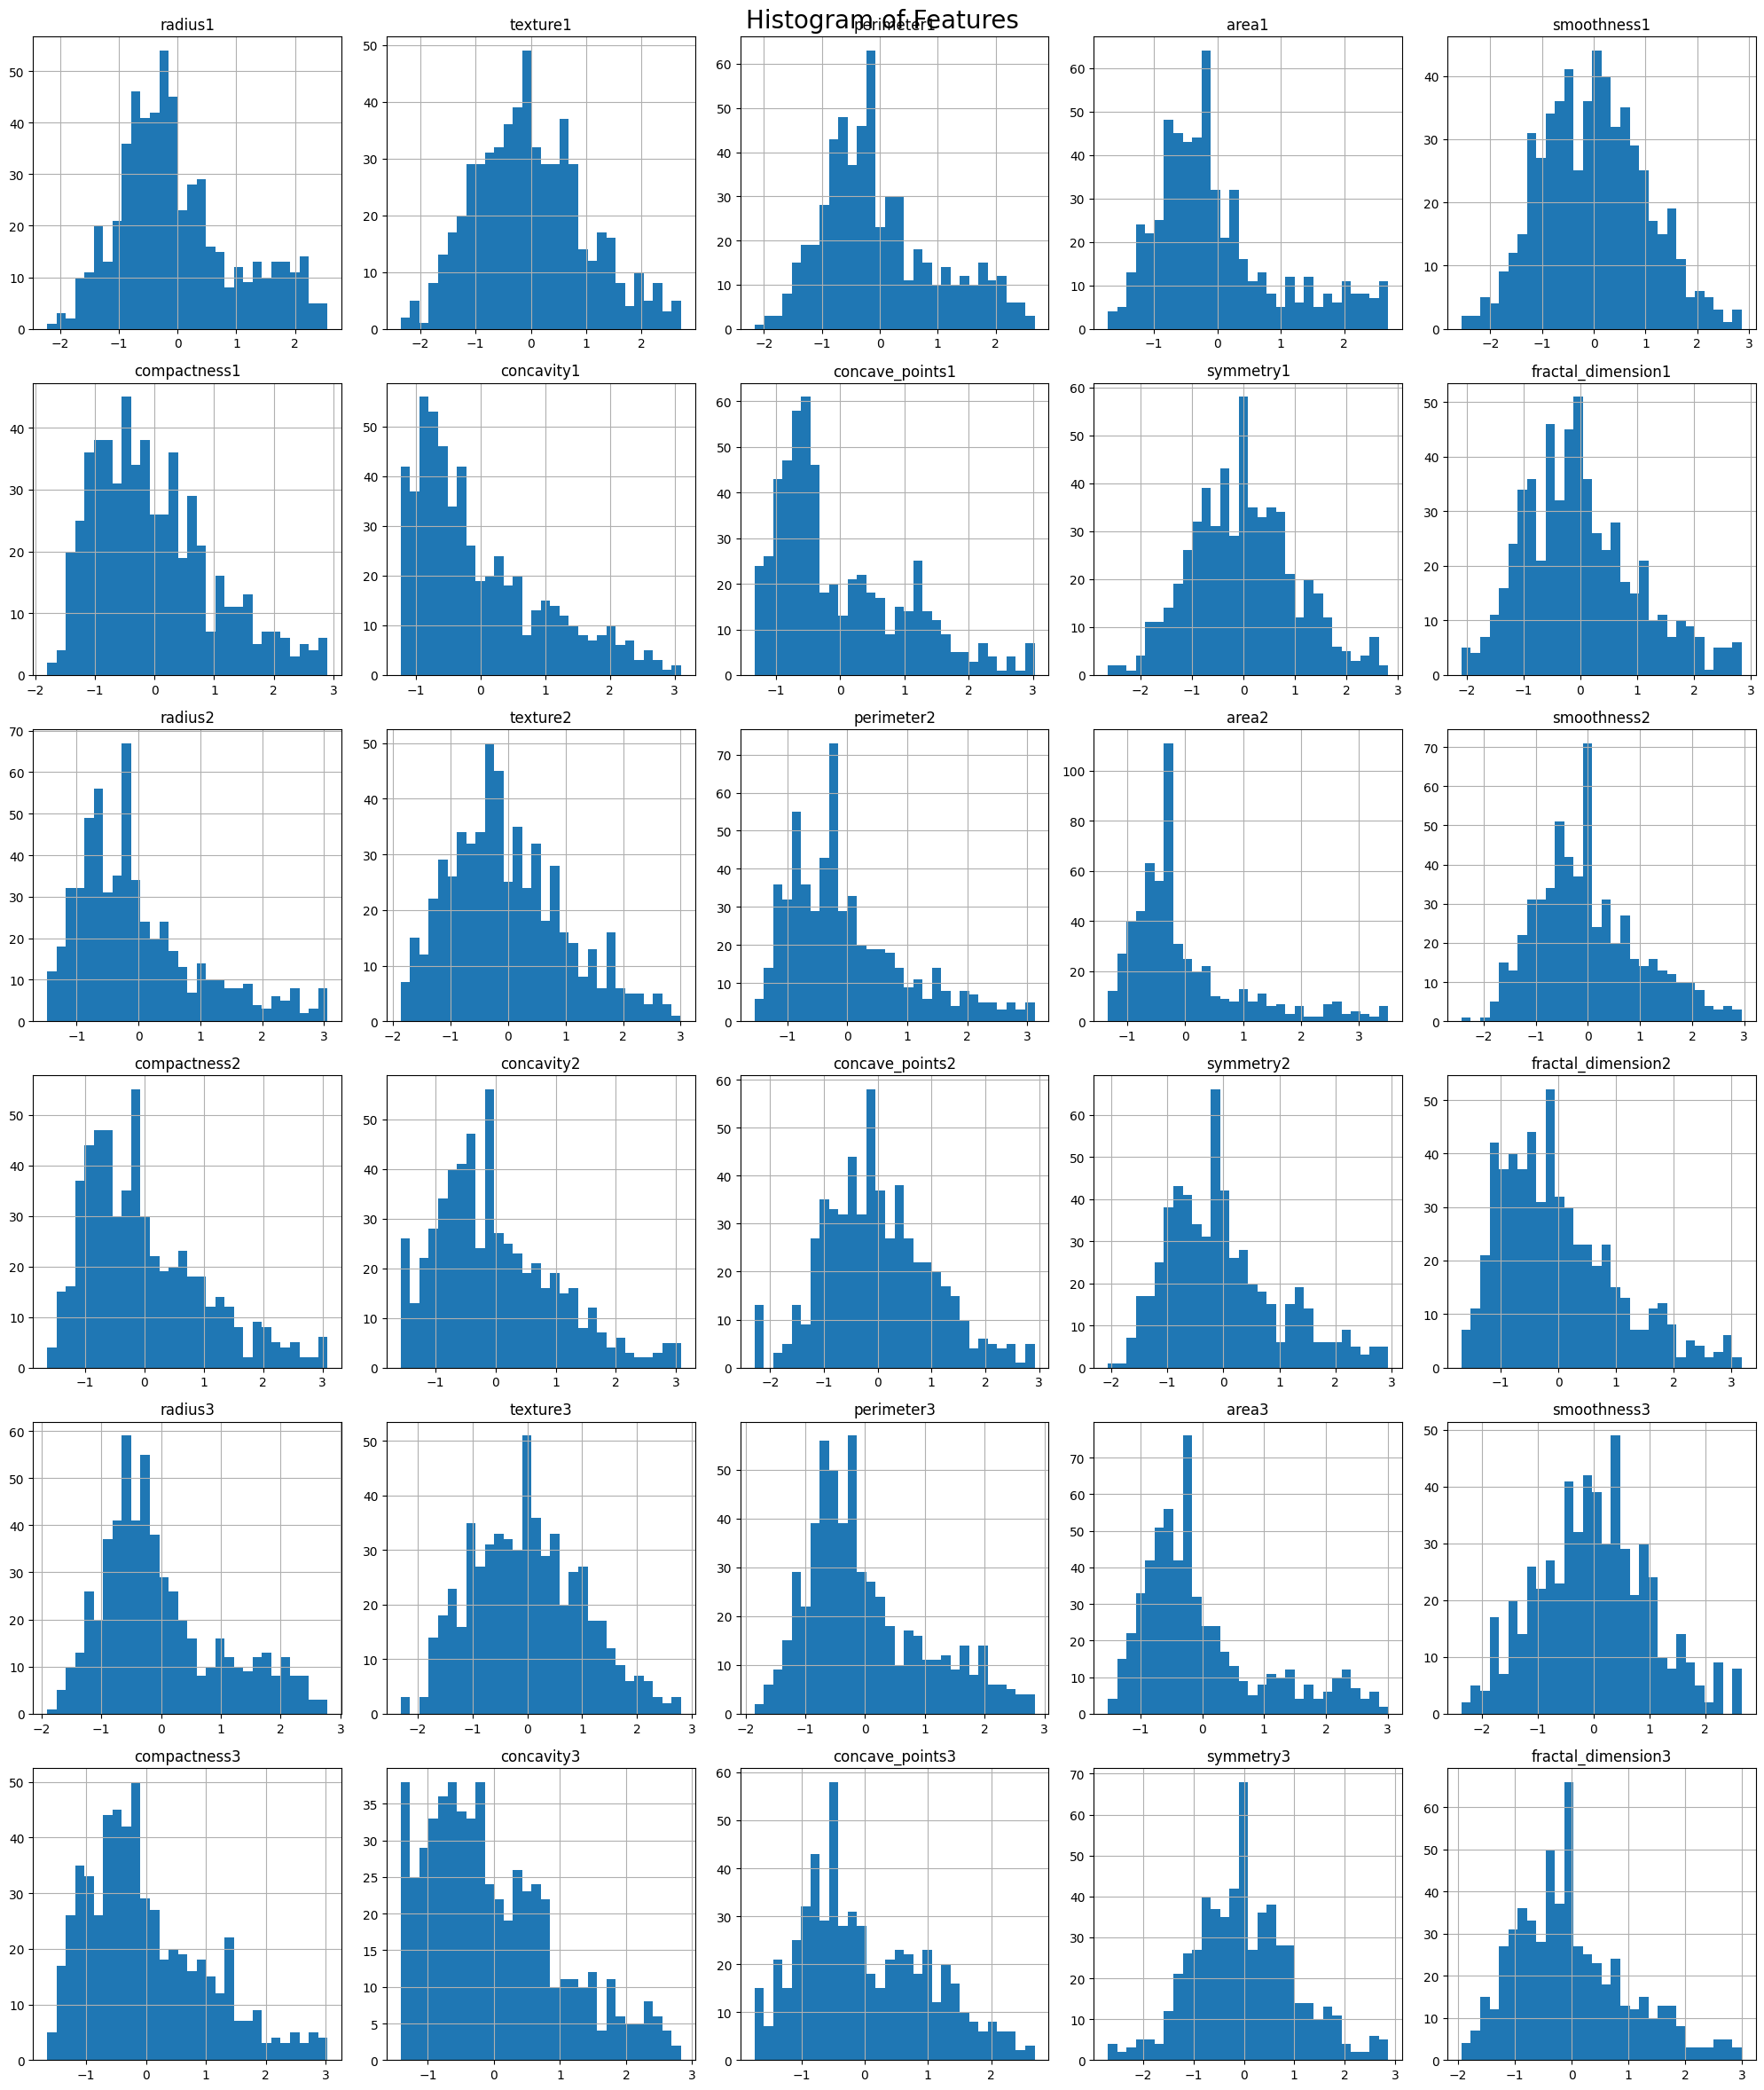

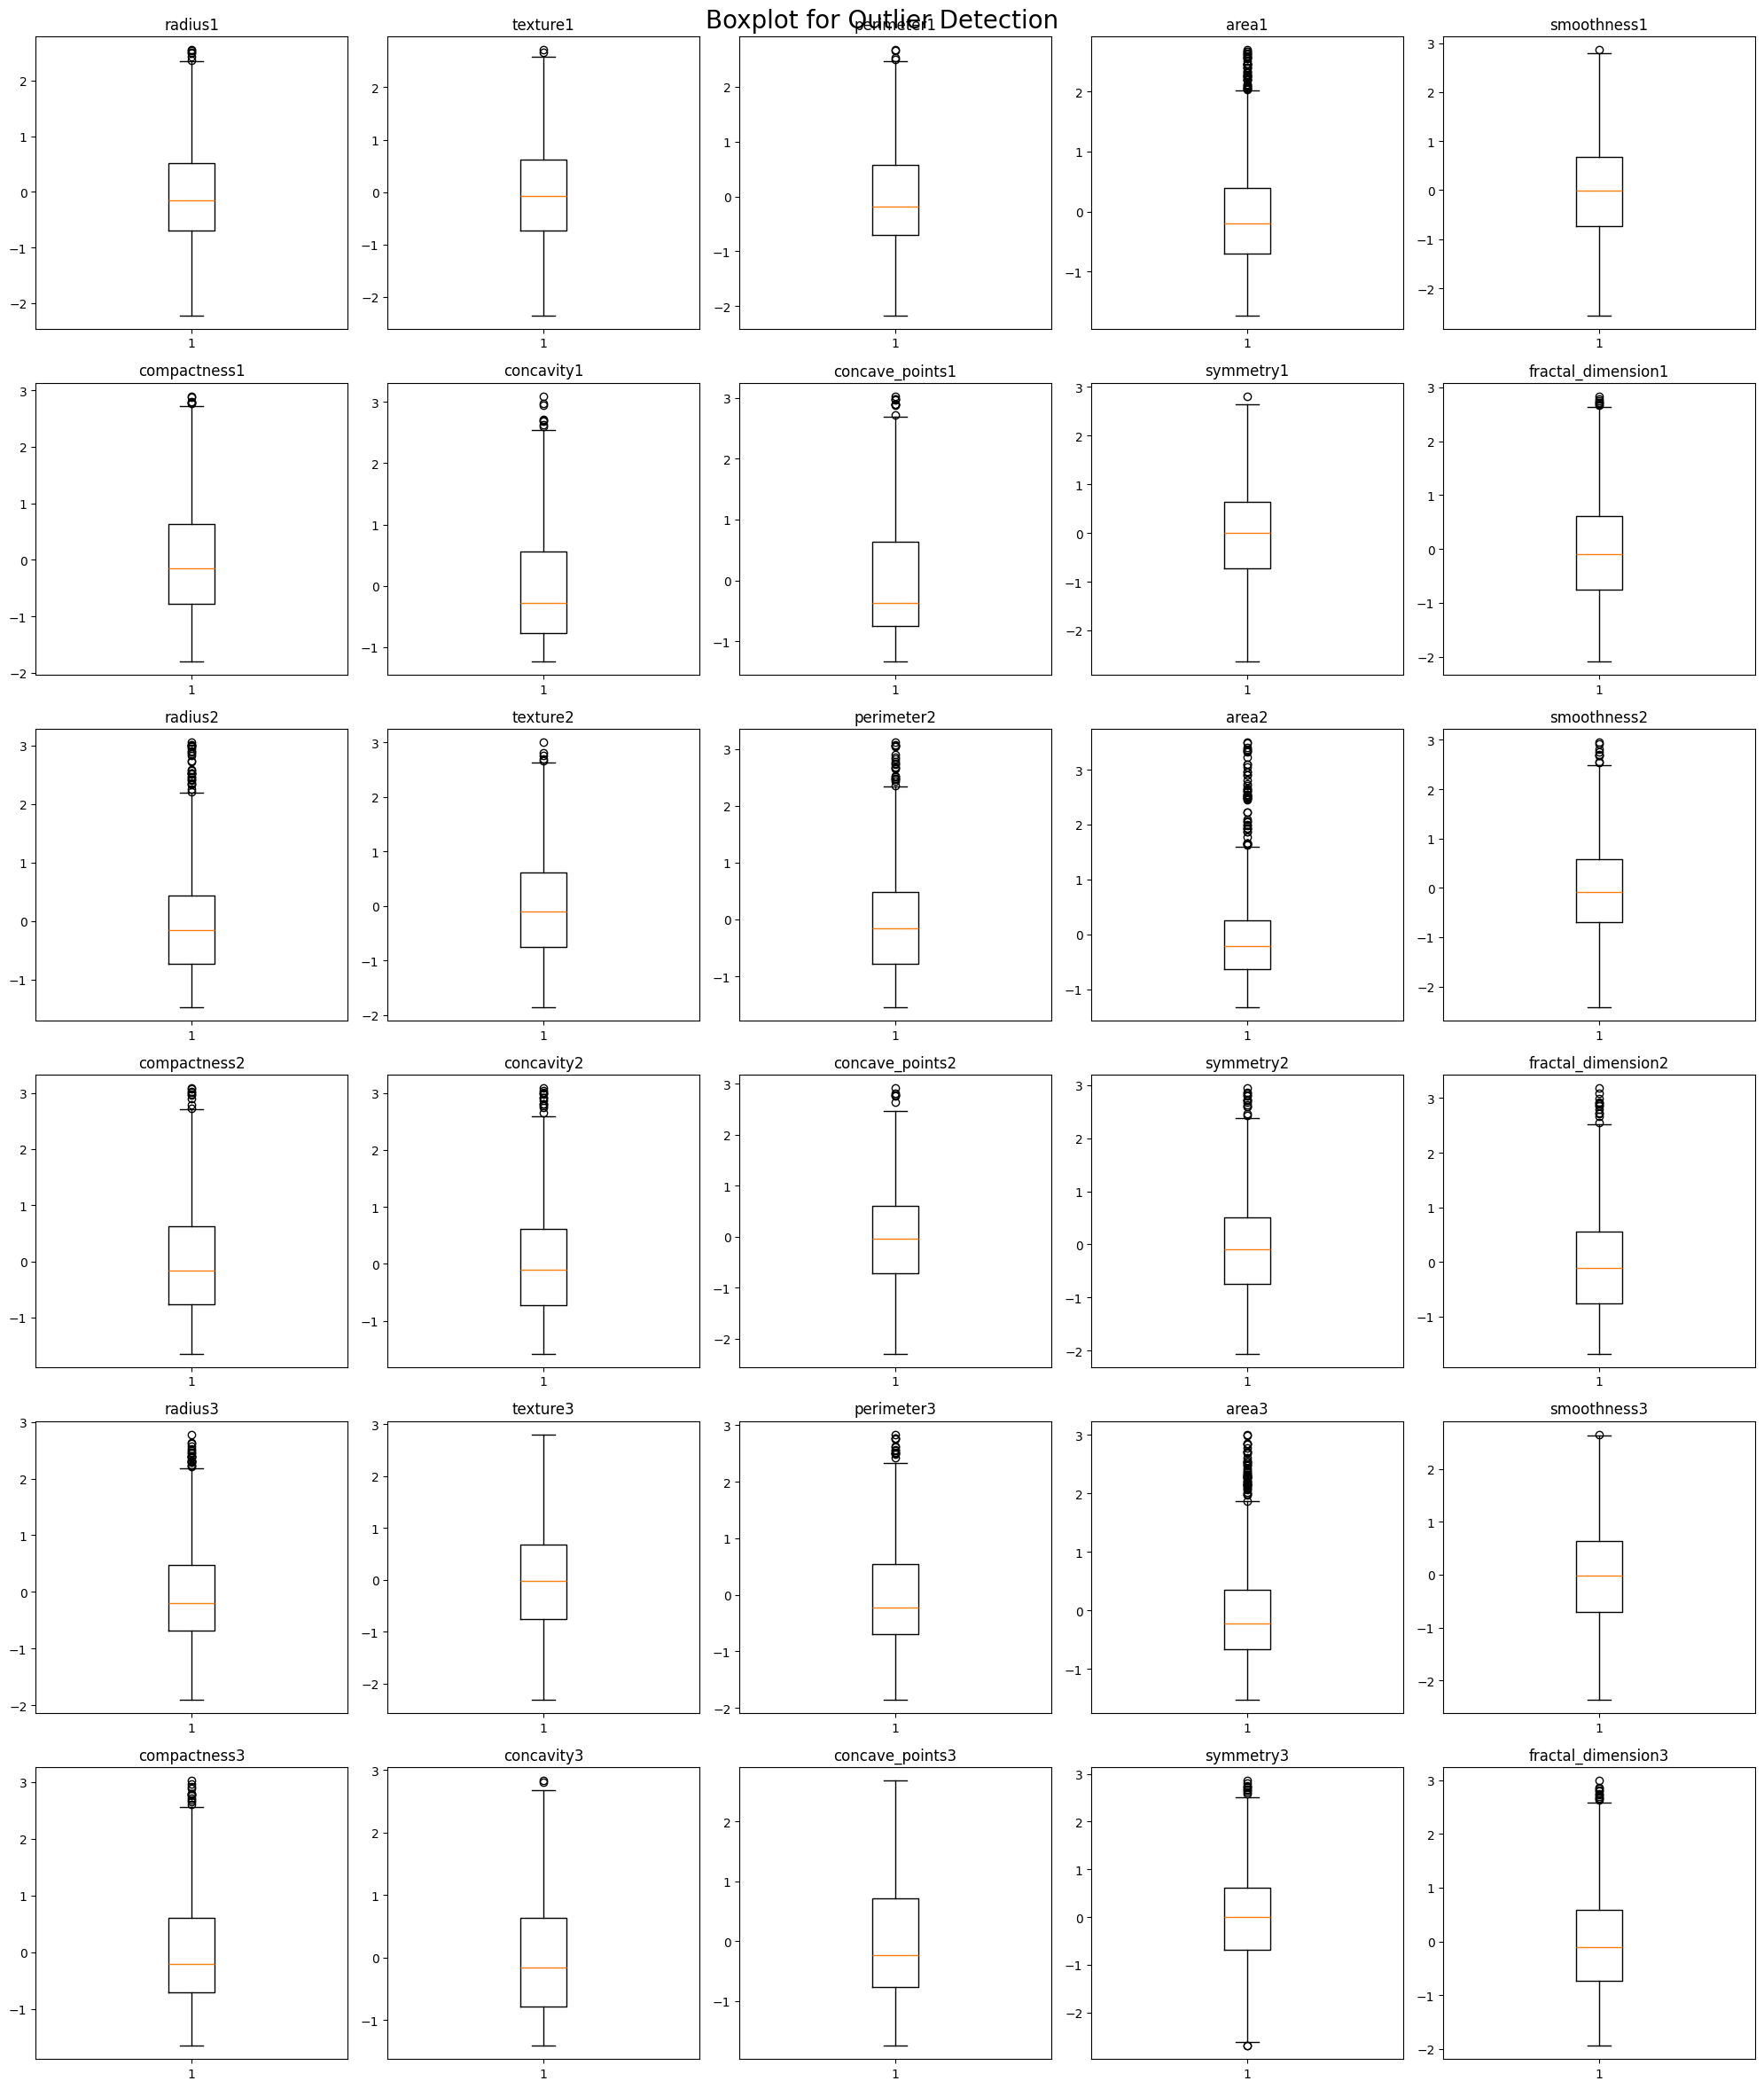

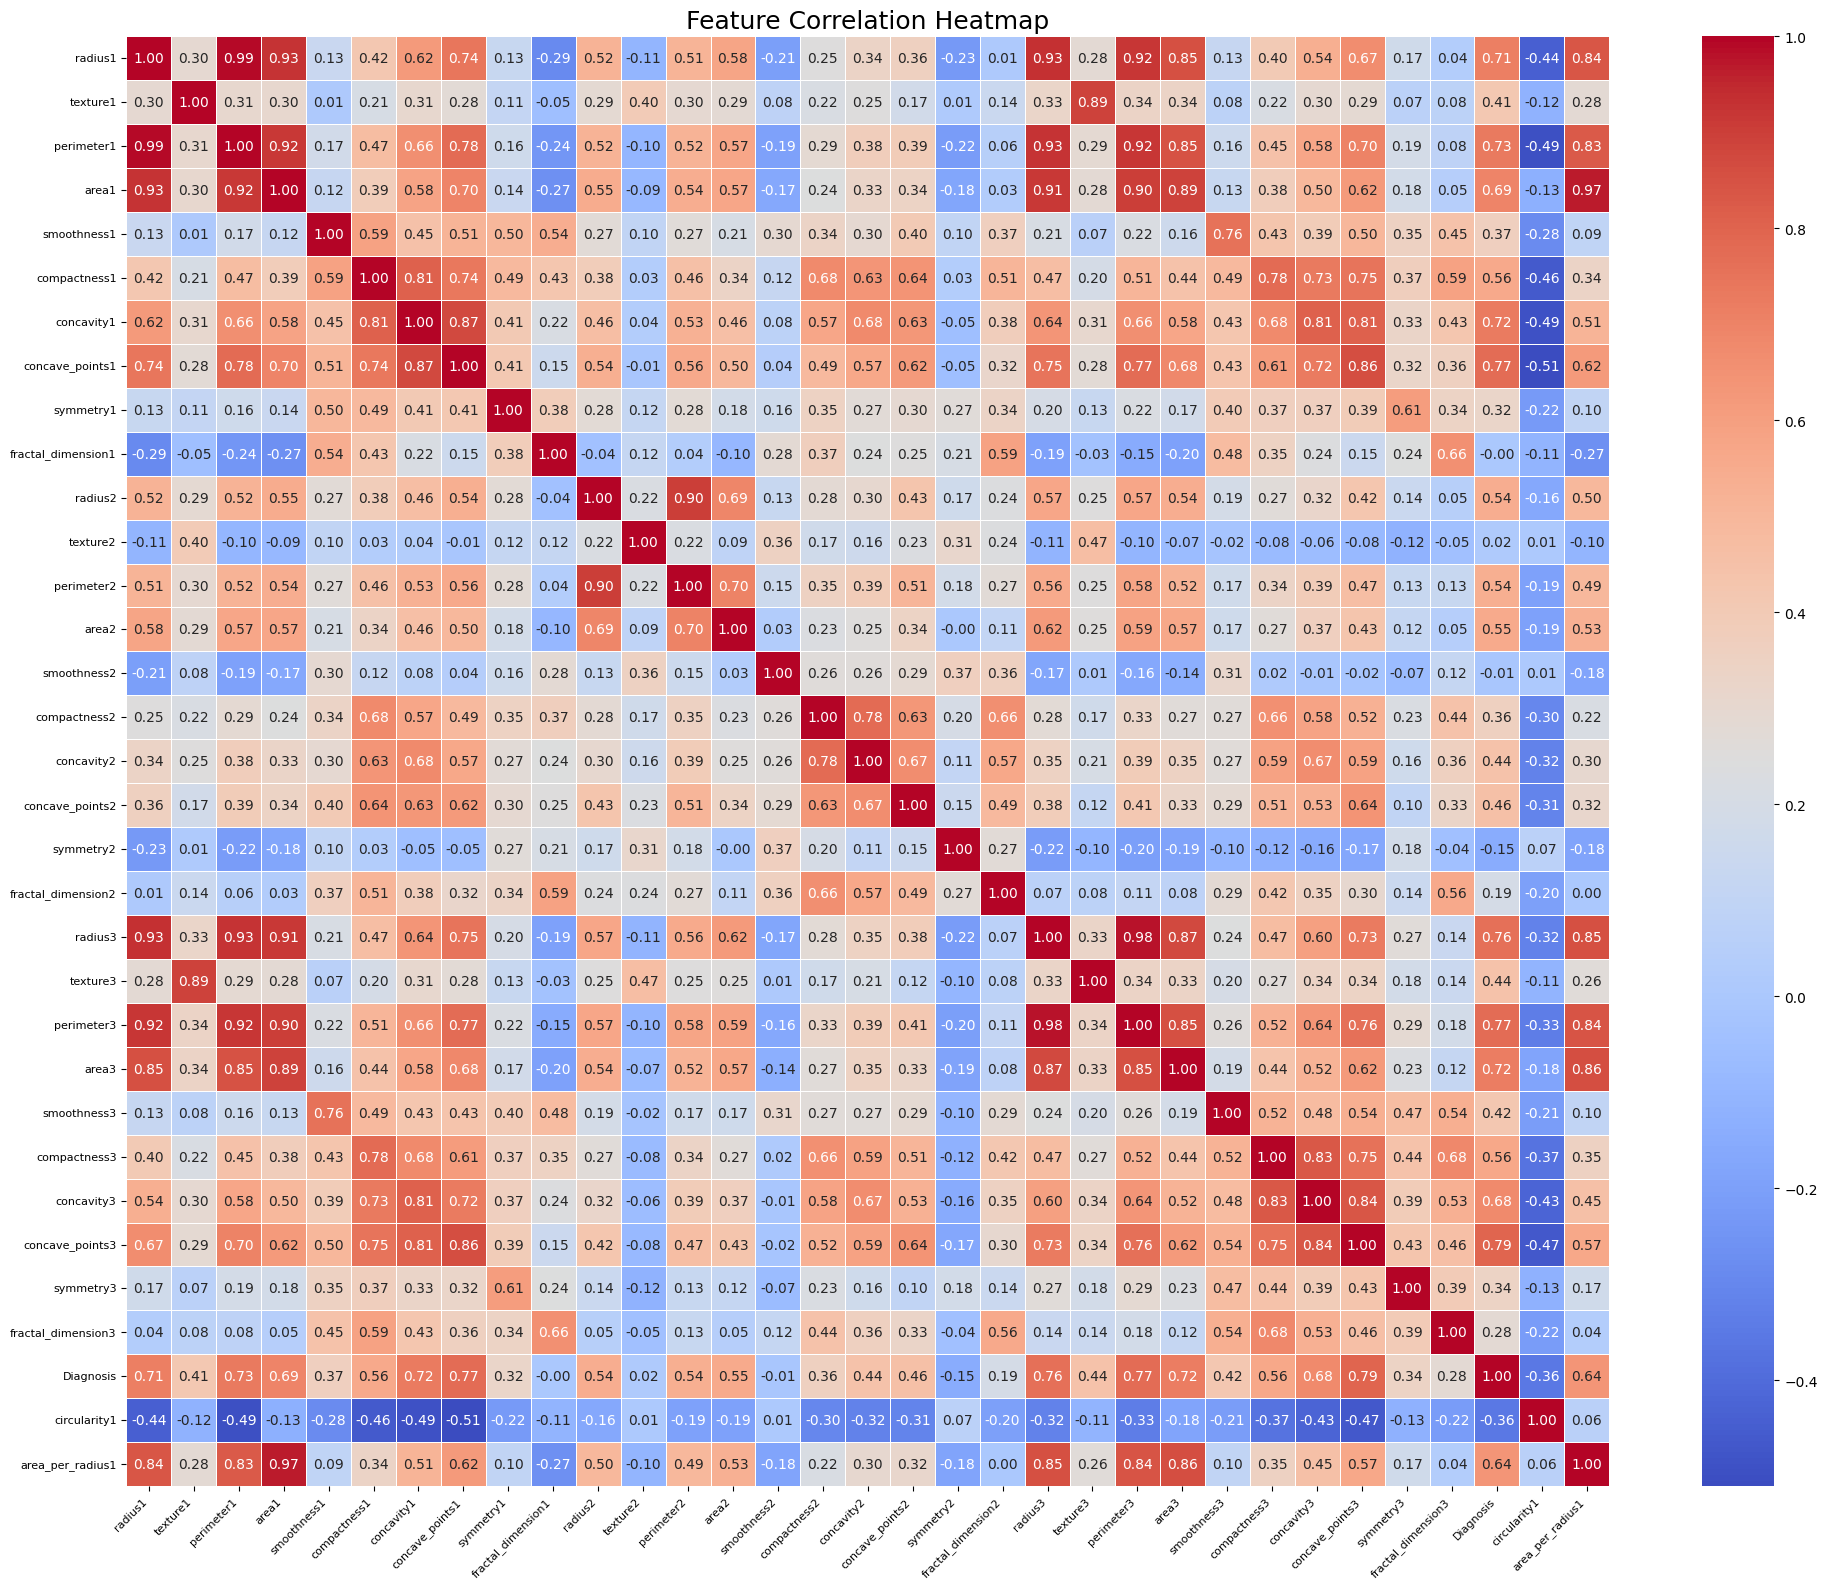

In [ ]:
# --- Histogram Subplots ---
n_cols = 5  # Number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col)

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Histogram of Features", fontsize=20)
plt.tight_layout()
plt.show()

# --- Boxplot Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplot for Outlier Detection", fontsize=20)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    if is_classification:
        print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
        print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))
        print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
        print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # ROC Curve: Only for binary classification
        if len(np.unique(y_true)) == 2 and model is not None and hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            auc_score = roc_auc_score(y_true, y_probs)
            print("ROC AUC Score:", round(auc_score, 4))

            # Plot ROC
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {dataset_name}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        n, p = X.shape
        r2 = r2_score(y_true, y_pred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R2 Score:", r2)
        print("Adjusted R2 Score:", adjusted_r2)


In [ ]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()

In [ ]:
def run_logistic_regression_with_pca(X_train, X_val, X_test, y_train, y_val, y_test, use_pca=False):
    # Base pipeline (scaling is important for LR)
    steps = [("scaler", StandardScaler())]

    # Add PCA if requested
    if use_pca:
        steps.append(("pca", PCA(n_components=0.95, random_state=42)))  # keep 95% variance

    steps.append(("logreg", LogisticRegression(max_iter=500, random_state=42)))
    pipe = Pipeline(steps)

    # Hyperparameter grid
    param_grid = {
        "logreg__C": [0.01, 0.1, 1, 10, 100],
        "logreg__penalty": ["l2"],  # stick with l2 (safest across solvers)
        "logreg__solver": ["lbfgs", "saga"]  # support l2
    }

    grid = GridSearchCV(
        pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print(f"{'PCA' if use_pca else 'No PCA'} Best Params:", grid.best_params_)

    # Predictions
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    return best_model, y_val_pred, y_test_pred

X = df.drop(columns=[target])
y = df[target]

# Train / temp split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Validation / test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Run both versions
best_models = {}
y_val_preds = {}
y_test_preds = {}

for label, use_pca in [("LogReg_NoPCA", False), ("LogReg_PCA", True)]:
    model, y_val, y_test = run_logistic_regression_with_pca(
        X_train, X_val, X_test, y_train, y_val, y_test, use_pca=use_pca
    )
    best_models[label] = model
    y_val_preds[label] = y_val
    y_test_preds[label] = y_test

No PCA Best Params: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
PCA Best Params: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


In [ ]:
# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    if is_classification:
        print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
        print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))
        print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
        print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # ROC Curve: Only for binary classification
        if len(np.unique(y_true)) == 2 and model is not None and hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            auc_score = roc_auc_score(y_true, y_probs)
            print("ROC AUC Score:", round(auc_score, 4))

            # Plot ROC
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {dataset_name}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        n, p = X.shape
        r2 = r2_score(y_true, y_pred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R2 Score:", r2)
        print("Adjusted R2 Score:", adjusted_r2)


In [ ]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()


Results for LogReg_NoPCA

--- Validation Set ---

 Evaluation - LogReg_NoPCA - Validation
Accuracy : 0.9912
Precision: 0.9913
Recall   : 0.9912
F1 Score : 0.9912

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

ROC AUC Score: 1.0


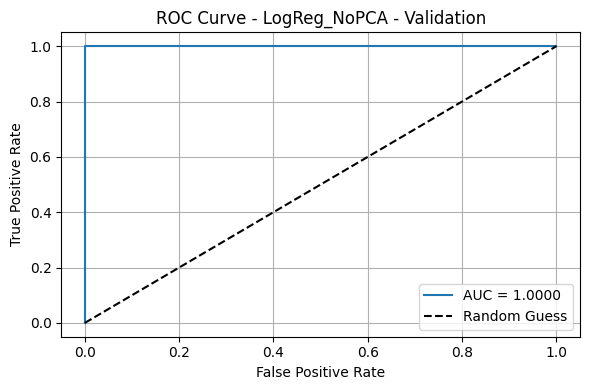

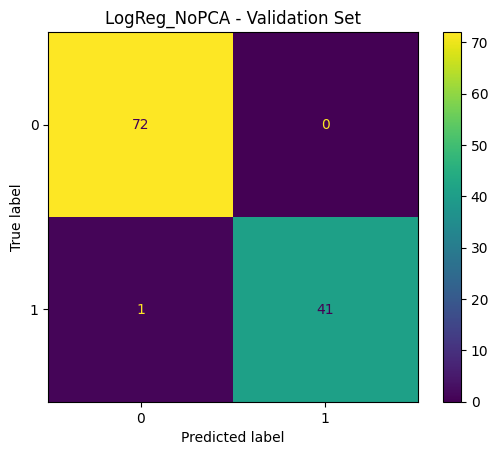


--- Test Set ---

 Evaluation - LogReg_NoPCA - Test
Accuracy : 0.9912
Precision: 0.9913
Recall   : 0.9912
F1 Score : 0.9912

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        74
           1       1.00      0.97      0.99        40

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

ROC AUC Score: 1.0


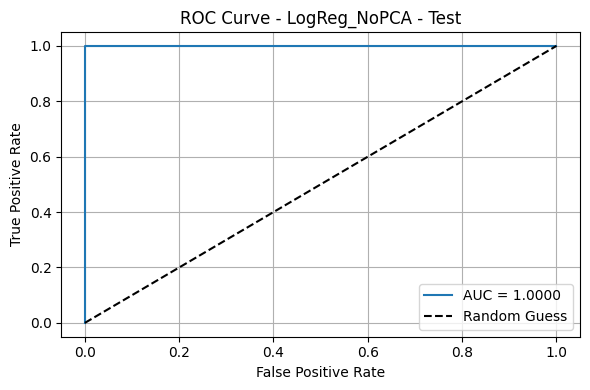

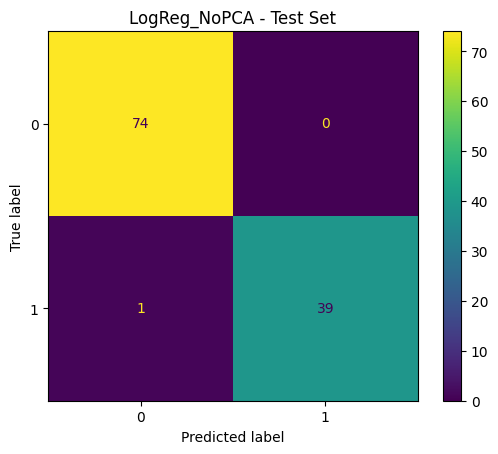


Results for LogReg_PCA

--- Validation Set ---

 Evaluation - LogReg_PCA - Validation
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        42

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

ROC AUC Score: 1.0


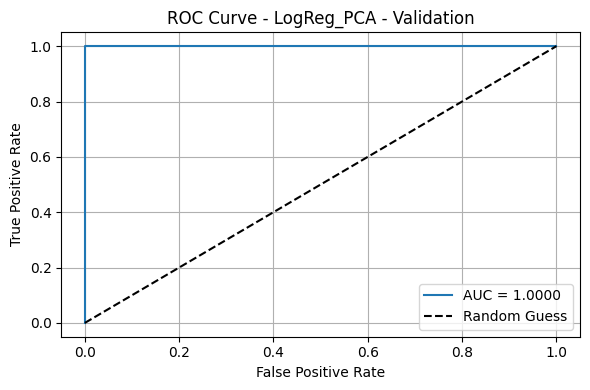

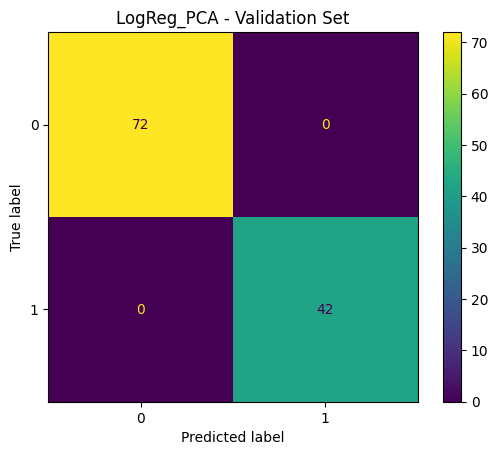


--- Test Set ---

 Evaluation - LogReg_PCA - Test
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00        40

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

ROC AUC Score: 1.0


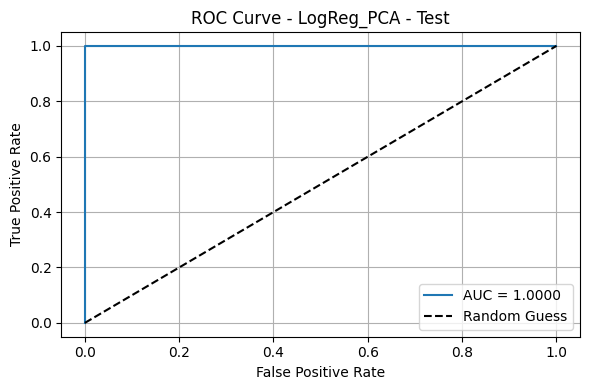

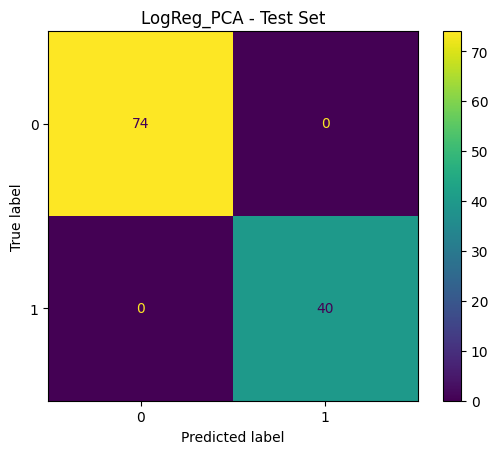

In [ ]:
# Evaluate both models on Validation and Test sets
for label in ["LogReg_NoPCA", "LogReg_PCA"]:
    print(f"\n{'='*50}")
    print(f"Results for {label}")
    print(f"{'='*50}")

    model = best_models[label]
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Validation
    print("\n--- Validation Set ---")
    evaluate_model(y_val, y_val_preds[label], True, X_val, model, f"{label} - Validation")
    plot_confusion_matrix(y_val, y_val_preds[label], f"{label} - Validation Set")
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

    # Test
    print("\n--- Test Set ---")
    evaluate_model(y_test, y_test_preds[label], True, X_test, model, f"{label} - Test")
    plot_confusion_matrix(y_test, y_test_preds[label], f"{label} - Test Set")
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

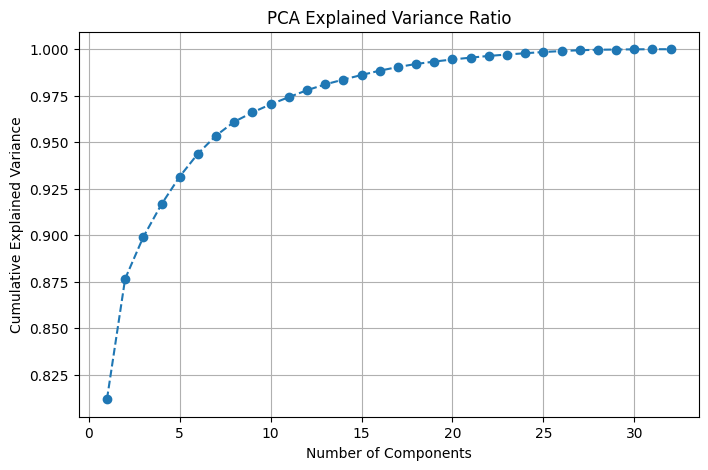

Optimal number of components to retain 95% variance: 7


In [ ]:

# 1. Fit PCA on training data only (to avoid data leakage!)
pca = PCA()
pca.fit(X_train)

# 2. Explained Variance Ratio
evr = pca.explained_variance_ratio_
cumulative_evr = np.cumsum(evr)

# 3. Plot to visualize how many components explain the variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_evr)+1), cumulative_evr, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratio")
plt.grid(True)
plt.show()

# 4. Choose number of components manually
# Example: choose smallest k such that at least 95% variance is retained
k = np.argmax(cumulative_evr >= 0.95) + 1
print(f"Optimal number of components to retain 95% variance: {k}")

# 5. Refit PCA with chosen k
pca = PCA(n_components=k)
X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)
X_test_pca  = pca.transform(X_test)
